## **Far Ultraviolet Spectroscopic Explorer (FUSE) Tutorial**

**Tutorial:** This tutorial demonstrates how to open and load FUSE FITS files with binary data tables, create spectrograms, and analyze their data. 

**Mission and Instrument:** [FUSE Mission](https://www.asc-csa.gc.ca/eng/satellites/fuse.asp). Data in this tutorial is taken by the instrument, Far Ultraviolet (FUV) instrument. 

**Astronomical Target:** This tutorial is delimited to white dwarfs. In particular, WD0038+199. This can be extended to other astronomical objects such as galaxies and planets. 

**System Requirements:** Access to the Internet, Python version 3.9 or above, Windows/MacOS/Linux

**Tutorial Level:** Intermediate

---
**MIT License**

Copyright (c) His Majesty the King in Right of Canada, as represented by the Canadian Space Agency, 2024.

Droit d’auteur (c) Sa Majesté le Roi du chef du Canada, représentée par l'Agence Spatiale Canadienne, 2024.

For more information, please refer to the License.txt file.

---  
**About the FUSE Project**  

The Far Ultraviolet Spectrpscopic Explorer (FUSE) was a collaboration between the Canadian Space Agency (CSA), the National Aeronautics and Space Administration (NASA), the Centre national d'etudes spatiales (CNES), and John Hopkins University. The University of Colorado in Boulder and the University of California in Berkeley were also collaborators on the project. It launched on June 24, 1999 and was operational until October 18th, 2007. FUSE has been used to observe nearly 3000 different astronomical objects with a total of 64 million seconds of successful observing time.  

You can read more about the general mission here: https://archive.stsci.edu/fuse/overview.html 


**About the Mission**  

The aim of this mission was to conduct various scientific experiments with precision never seen before in the ultraviolet (UV) band. The Earth's atmosphere (specifically the thermosphere) absorbs UV rays making ground observations near-impossible. This incentivizes scientists to develop telescopes that can be sent to space and absorb UV rays to study a variety of subjects covering a range of characteristics observed in celestial objects (i.e. [FUSE Magellanic Clouds Legacy Project](https://archive.stsci.edu/prepds/fuse_mc/)) to atlases of celestial objects (e.g. [FUSE Atlas of Starburst Galaxies](https://archive.stsci.edu/prepds/fuse_galaxies/)). One of the primary missions was to study Deuterium (D / D-I) or Hydrogen-II in the local universe. 

You can read more about the high-profile science goals and summaries here: https://archive.stsci.edu/fuse/scisumm/

---
**Acknowledgements**  

Based on observations made with the NASA-CNES-CSA Far Ultraviolet Spectroscopic Explorer (FUSE). FUSE is operated for NASA by the Johns Hopkins University under NASA contract NAS5-32985. 

In [ ]:
## Import Libraries ##

#For importing data from FITS images
import os
from astropy.io import fits
from astropy.table import Table

#For cleaning the data and conducting scientific analyses
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as sps
import copy
from math import floor
from scipy.fft import rfft, irfft
from scipy.interpolate import CubicSpline
from scipy.stats import binned_statistic

#For creating the sky map
from astropy.coordinates import SkyCoord
from astropy.visualization import astropy_mpl_style
from imageio.v2 import imread

#For the colour bar 
from matplotlib.colors import Normalize
from matplotlib.markers import MarkerStyle
from matplotlib.transforms import Affine2D


Note: Astronomical spectroscopy is very dependent on manual verification. And so, it is recomended that the user procedes with the tutorial using the same file / target before experimenting with other targets. With other targets, the user may need to adjust the detector region they are looking at in order to properly clean or analyze the data.  

You can find this file in the CADC under the program ID: P1040201

### Import Files

There are two main approaches to obtain FUSE files.  
(1) Through the [CADC](https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/fuse/)     
(2) Through the [MAST archive](https://archive.stsci.edu/fuse/)  

The Canadian Astronomy Data Centre (CADC) allows users to easily select their desired target and specified filters. 
- Go to the [CADC website](https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/fuse/) and filter for the FUSE mission.
- Select desired specifications and click "Search".
- A list will appear where you can select and download the desired files. There is an option to preview the data as well.  
*Note: this will download a .tar file that needs to be extracted before accessing all of the files (see "Extracting Tar Files" below).

The Mikulski Archive for Space Telescopes (MAST) hosts archived data and the FUSE website which includes data handbooks and technical information about the mission. You can access the website here: https://archive.stsci.edu/fuse/.   
To download the required files: 
- Using the left sidebar, navigate to the "About FUSE Data" tab. A pop-out will appear, and there you can click on "Retrieve FUSE Data".
- Under the sub-heading, "Retrieving from the anonymous ftp area", click on the [archive link](https://archive.stsci.edu/pub/fuse/data/) at the end of the paragraph. 
- A list of folders will appear indicating the target and exposure.
- Refer to the [file naming guide](https://archive.stsci.edu/fuse/DH_Final/Science_Data_Files.html#SECTION00712000000000000000) in the data handbook and search for the folder containing your desired target.
- For the purposes of this tutorial, download a file ending with "...all4ttagfcal.fit" or "...all4histfcal.fit".  
*Note: this will download a single file.

On the FUSE Mission page, there is a data handbook and instrument handbook under "Documentation".  
Data Handbook: https://archive.stsci.edu/fuse/dh.html  
Instrument Handbook: https://archive.stsci.edu/fuse/ih.html  

#### Extracting Tar Files  

To extract files from the tar file, start by either creating a new folder or run the code block below. If you choose to create your own folder, remember to rename the extract path below. Then, simply right click on the tar file, select "Extract All...", and save the files to the new folder. 

In [ ]:
#This will create a folder for your extracted FUSE files if it does not already exist
extract_foldername = 'Extracted FUSE Files'
extract_path = os.path.realpath(extract_foldername)

if not os.path.exists(extract_path):
    os.mkdir(extract_path)

#OR if you create your own folder
#extract_path = "your folder path here"

### Check Data Usability
Some files will contain no data as a result of the instrument or processing errors. Use the following code to check the comments in the header which will indicate if the data is usable. An example of a comment indicating unusable data is below: 

*File Name: m90055020011asic4ttagfcal.fit | Comment:*
*Detector at SAA voltage throughout exposure*
*CalFUSE v3.2.2   2008-05-14*


*No good data.  Output arrays set to zero.*  
*CalFUSE v3.2.2   2008-05-14*

In [3]:
# Check to see if the data is usable
for root, dirs, files in os.walk(extract_path):
    for filename in files: 
        if filename.endswith("4ttagfcal.fit"):
            try:
                file = os.path.join(root, filename)
                hdu = fits.open(file)
                Comment = hdu[0].header["COMMENT"]
                print (f"File Name: {filename} | Comment: {Comment}")
                hdu.close()
            except:
                print ("This file has no data")

File Name: p104020100000all4ttagfcal.fit | Comment: 
Index to file extensions:
Extension 0   This Header
Extension 1   1ALIF
Extension 2   1BLIF
Extension 3   2BLIF
Extension 4   2ALIF
Extension 5   1ASIC
Extension 6   1BSIC
Extension 7   2BSIC
Extension 8   2ASIC

File Name: p104020100000ano4ttagfcal.fit | Comment: 
Index to file extensions:
Extension 0   This Header
Extension 1   1ALIF
Extension 2   1BLIF
Extension 3   2BLIF
Extension 4   2ALIF
Extension 5   1ASIC
Extension 6   1BSIC
Extension 7   2BSIC
Extension 8   2ASIC

This file has no data
File Name: p104020100100all4ttagfcal.fit | Comment: 
This file contains no data.
Its header keywords are used by the DADS cataloging software.
CalFUSE v3.2.1   2007-11-21

This file has no data
This file has no data


### Create the Spectrogram

To begin we will look at a single file and extract the recorded wavelengths and flux. 

We want to use the "all4ttagfcal.fit" or "all4histfcal.fit" files because they contain the data from every detector. The naming of the detectors refer to which sensor the data was captured through (LiF or SiC) and which side they were captured on (A or B). These detectors can only accept a limited range but when combined together, they create the full UV spectrum. This is a good place to start for a beginner.

---
**Spectrograms**  

A spectrogram (the kind used in astronomy, not to be confused with sound spectrograms or sonograms) is a plot of wavelengths against their measured flux. This is also called a *stellar spectrum*. All objects that emit light can be analyzed using a spectrogram which reveals the chemical make-up. What the exact spectrogram will look like depends on the range of light you're examining, if there are any filters on the camera allowing only certain elements to pass through, and the precision of the equipment being used. 

Filename: C:\Users\spunchiwickrama\Documents\FUSE Tutorial\p104020100000all4ttagfcal.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     378   ()      
  1  1ALIF         1 BinTableHDU     31   7694R x 3C   [1E, 1E, 1E]   
  2  1BLIF         1 BinTableHDU     31   7694R x 3C   [1E, 1E, 1E]   
  3  2BLIF         1 BinTableHDU     31   7693R x 3C   [1E, 1E, 1E]   
  4  2ALIF         1 BinTableHDU     31   7693R x 3C   [1E, 1E, 1E]   
  5  1ASIC         1 BinTableHDU     31   7693R x 3C   [1E, 1E, 1E]   
  6  1BSIC         1 BinTableHDU     31   7693R x 3C   [1E, 1E, 1E]   
  7  2BSIC         1 BinTableHDU     31   7693R x 3C   [1E, 1E, 1E]   
  8  2ASIC         1 BinTableHDU     31   7694R x 3C   [1E, 1E, 1E]   


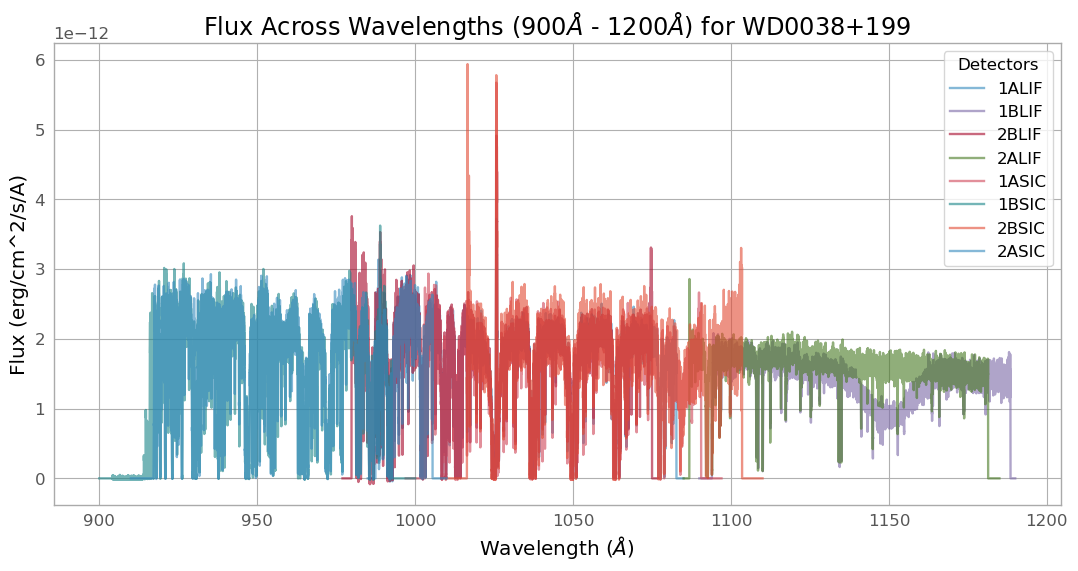

In [51]:
#Input the name of the file you would like to analyse
#Ensure the python notebook is in the same location as this file
FileName = "p104020100000all4ttagfcal.fit"
FilePath = os.path.realpath(FileName)
hdu = fits.open(FilePath)

#Display HDUList info
hdu.info()

#Extract RA, DEC, and Target Name from the header of the FITS file
RA = hdu[0].header["RA_TARG"]
DEC = hdu[0].header["DEC_TARG"]
TargetName = hdu[0].header["TARGNAME"]

#Plot the data
plt.figure(figsize = (13, 6))
SpectrumData = pd.DataFrame()
for index in range(1, len(hdu)):
    Detector = hdu[index].header["EXTNAME"]
    dict_hdu = {"Detector": Detector, "Wavelengths": Table(hdu[index].data)["WAVE"], "Flux": Table(hdu[index].data)["FLUX"]}
    SpectrumData = SpectrumData._append(dict_hdu, ignore_index= True)
    plt.plot(Table(hdu[index].data)['WAVE'], Table(hdu[index].data)['FLUX'], label = Detector, alpha = 0.6)

SpectrumData = SpectrumData.rename(index = SpectrumData['Detector'])
plt.legend(title = "Detectors")
plt.grid(True)
plt.xlabel("Wavelength ($\\AA$)")
plt.ylabel("Flux (erg/cm^2/s/A)")
plt.title(f"Flux Across Wavelengths (900$\\AA$ - 1200$\\AA$) for {TargetName}")
plt.show()
hdu.close()

### Cleaning the Data
There are two main features we're going to be looking at and cleaning up: Airglow Emissions and "Worms".

#### Identifing and Removing Airglow Emissions

Airglow refers to the faint glow in the Earth’s upper atmosphere caused by molecules being excited due to electromagnetic radiation emitted by the Sun. Since the detectors lack a shutter, the rays from this glow can be captured, appearing as emission lines in the stellar spectrum These lines are discussed on the FUSE Mission's website as a caveat to look out for. In research, the verficiation and removal of airglow lines is very involved so for this tutorial, we will identify the lines using a predetermined list and correct the spectra in a basic manner. More about airglow emissions can be found [here by the FUSE team](https://archive.stsci.edu/fuse/DH_Final/Factors_Affecting_FUSE_Data.html#SECTION001010000000000000000) and [here by NASA Earth Observatory](https://earthobservatory.nasa.gov/images/147122/aurora-meet-airglow). It is worth noting that the airglow emissions strongly correlate to the Lyman series.

**Day + Night vs. Night Only Data**  

The telescope data from the oribital Day + Night cycle has a risk of taking in airglow emissions from the Earth while the orbital Night Only cycle avoids that entirely. There is value in the Day + Night cycle data which is why we still consider it. Generally, Day + Night and Night Only follow similar trends so we will be reducing airglow by treating that region as if it was Night Only data. 


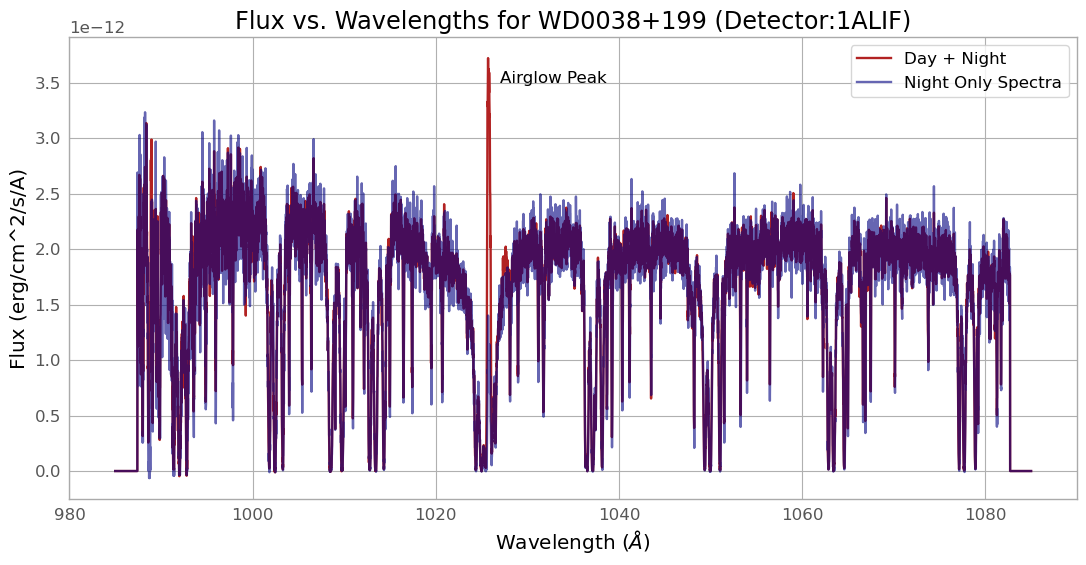

In [20]:
for root, dirs, files in os.walk(extract_path):
    for filename in files: 
        if filename.endswith("ano4ttagfcal.fit"):
            file = os.path.join(root, filename)
            hdu = fits.open(file)
            DataTable_Night = Table(hdu[1].data) 
            Wavelengths_Night = DataTable_Night["WAVE"]
            Flux_Night = DataTable_Night["FLUX"]

#For simplicity
Wavelengths_1ALiF = SpectrumData.loc["1ALIF", "Wavelengths"]
Flux_1ALiF = SpectrumData.loc["1ALIF", "Flux"]
Detector_1ALiF = SpectrumData.loc["1ALIF", "Detector"]

#Create general plot of flux across wavelengths
plt.figure(figsize = (13, 6))
plt.plot(Wavelengths_1ALiF, Flux_1ALiF, color = "firebrick", label = "Day + Night")
plt.plot(Wavelengths_Night, Flux_Night, color = "navy", alpha = 0.6, label = "Night Only Spectra")
plt.text(1027, 3.5e-12, "Airglow Peak")
plt.grid(True)
plt.legend()
plt.xlabel("Wavelength ($\\AA$)")
plt.ylabel("Flux (erg/cm^2/s/A)")
plt.title(f"Flux vs. Wavelengths for {TargetName} (Detector:{Detector_1ALiF})")
plt.show()

As seen here, there is a discrepency between the data collected during the Day + Night cycle vs the Night Only cycle. For the most part, the combined spectra show a general trend without many outliers but where the Day + Night significantly peaks above is an area of concern. This is an indicator of airglow that must be corrected. We can accomplish this by removing the airglow region and replace it with the Night Only data since the trends of Day + Night and Night Only are very similar. 

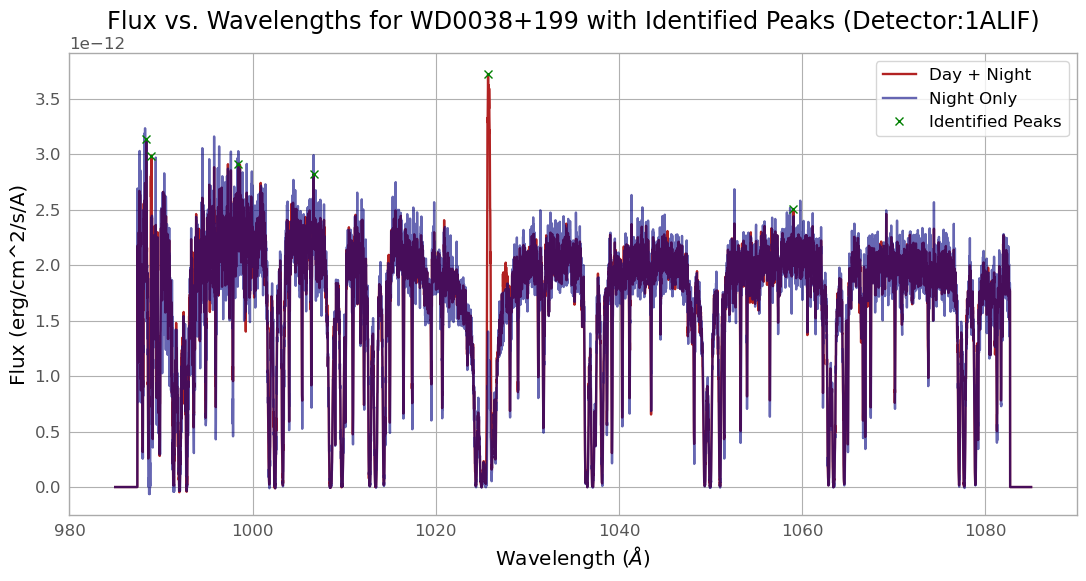

Airglow line 1025.72 for wavelength 1025.7099609375
Airglow line 1025.76 for wavelength 1025.7099609375
The following wavelength(s) is/are airglow peak(s): [1025.71]


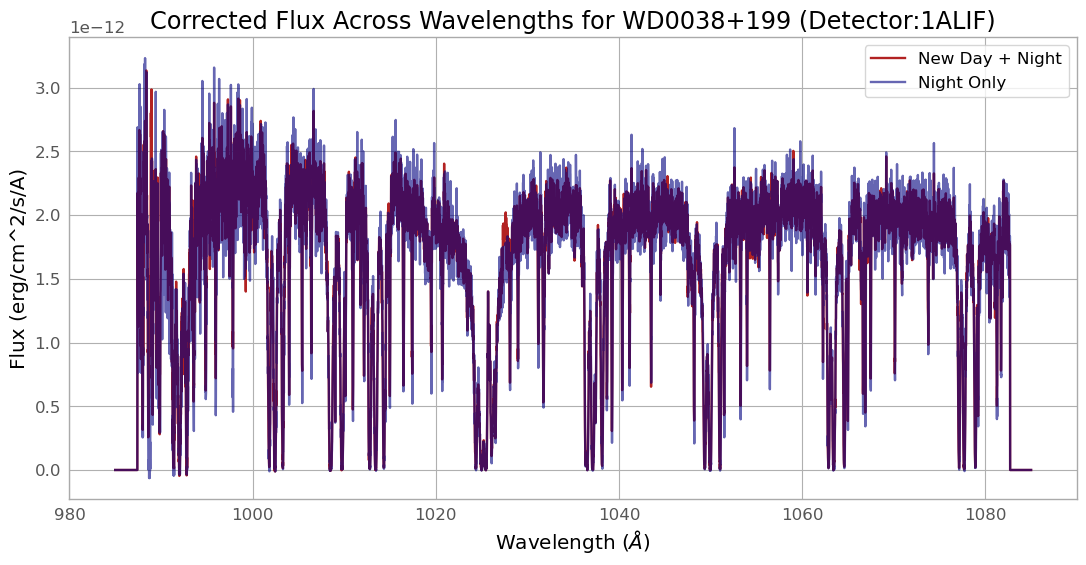

In [21]:
#Begin by determining the peaks of the spectrum
peaks, _ = sps.find_peaks(Flux_1ALiF, prominence=2.5e-12)

#Plot the data and peaks
plt.figure(figsize = (13, 6))
plt.plot(Wavelengths_1ALiF, Flux_1ALiF, color = "firebrick", label = "Day + Night")
plt.plot(Wavelengths_Night, Flux_Night, color = "navy", alpha = 0.6, label = "Night Only")
plt.plot(Wavelengths_1ALiF[peaks], Flux_1ALiF[peaks], "x", color = "green", label = "Identified Peaks")
plt.grid(True)
plt.legend()
plt.xlabel("Wavelength ($\\AA$)")
plt.ylabel("Flux (erg/cm^2/s/A)")
plt.title(f"Flux vs. Wavelengths for {TargetName} with Identified Peaks (Detector:{Detector_1ALiF})")
plt.show()

#Wavelengths where airglow is highly likely to happen:
AirglowLines = [926.23, 930.74, 937.8, 949.74, 972.54, 988.77, 990.20, 1025.72, 1025.76, 1027.43, 1039.23, 1040.94]

def flux_change(Wavelengths, Wave_Night, Flux, Flux_Night, peaks):
    """
    Removes the airglow region and returns the new flux
    Inputs:
    - Wavelengths (numpy array or astropy column): Wavelengths from the Day + Night spectrum
    - Wave_Night (numpy array or astropy column): Wavelengths from the Night Only spectrum
    - Flux (numpy array or astropy column): Flux from the Day + Night spectrum
    - Flux_Night (numpy array or astropy column): Flux from the Night Only spectrum
    - peaks (numpy array): Array containing the indices/locations of the peaks in the Day + Night spectrum

    Returns: 
    - New_Flux (astropy column): New flux of the Day + Night spectrum without the significant airglow emission 
    """
    New_Flux = copy.copy(Flux)
    
    #Determine wavelength at determined peak
    WavePeaks = np.array(Wavelengths[peaks])

    #Determine which of the peaks correlate to an airglow line
    WavetoAirglow = []
    for j in AirglowLines:
        for i in WavePeaks:
            if j + 0.1 >= i and j - 0.1 <= i: #the tolerence is quite small here but can be adjusted accoordingly(?)
                print (f"Airglow line {j} for wavelength {i}")
                WavetoAirglow.append(i)
    WavetoAirglow = list(set(WavetoAirglow))
    print (f"The following wavelength(s) is/are airglow peak(s): {WavetoAirglow}")
    
    #Determine the location of the wavelengths that are proven to correlate to an airglow line
    AirglowPeaks = []
    AirglowPeaks_Night = []
    for i in WavetoAirglow: 
        x = np.where(i == Wavelengths)[0][0]
        y = np.where(i == Wave_Night)[0][0]
        AirglowPeaks.append(x)
        AirglowPeaks_Night.append(y)

    #Change the value of the Flux to the night value
    for i in AirglowPeaks:
        for j in AirglowPeaks_Night:
            if New_Flux[i] > Flux_Night[j]:
                New_Flux[i-30:i+30] = Flux_Night[j-30:j+30]
    return New_Flux

NewFlux = flux_change(Wavelengths_1ALiF, Wavelengths_Night, Flux_1ALiF, Flux_Night, peaks)


#Plot corrected flux
plt.figure(figsize = (13, 6))
plt.plot(Wavelengths_1ALiF, NewFlux, color = "firebrick", label = "New Day + Night")
plt.plot(Wavelengths_Night, Flux_Night, color = "navy", alpha = 0.6, label = "Night Only")
plt.grid(True)
plt.legend()
plt.xlabel("Wavelength ($\\AA$)")
plt.ylabel("Flux (erg/cm^2/s/A)")
plt.title(f"Corrected Flux Across Wavelengths for {TargetName} (Detector:{Detector_1ALiF})")
plt.show()

Now that the airglow has been corrected, we can interpolate the data and find the average between the two data sets to get a better picture of the UV spectrum. 

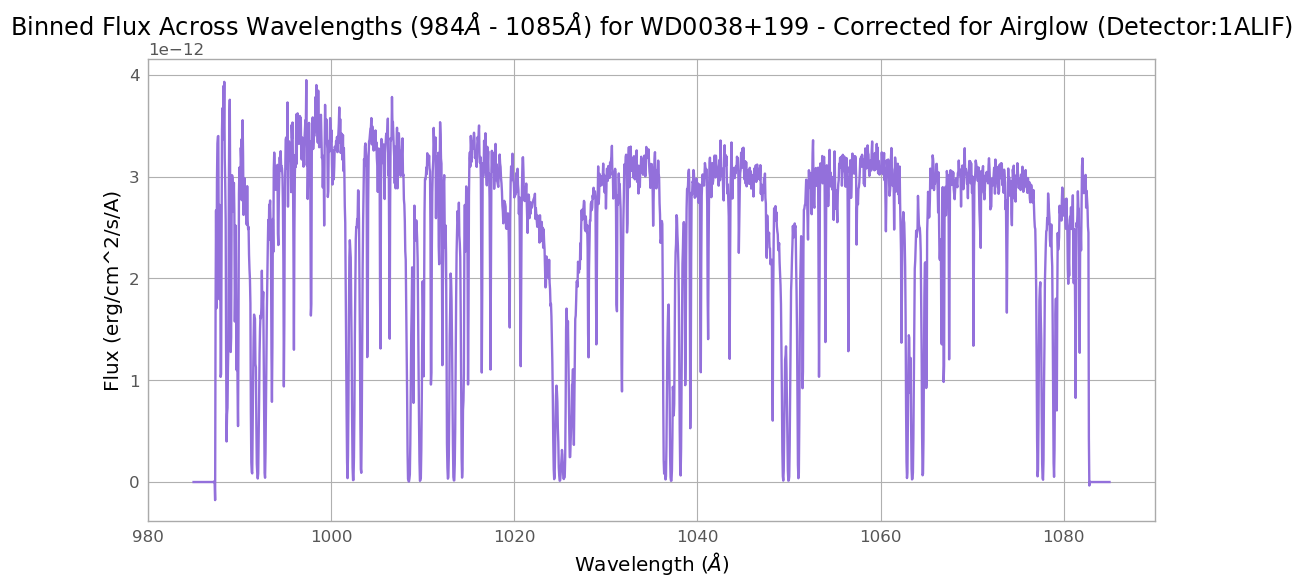

In [49]:
#Bin the data
stats_newflux, _, __ = binned_statistic(Wavelengths_1ALiF, NewFlux, bins = (floor(len(NewFlux)/3)))
stats_night, _, __ = binned_statistic(Wavelengths_Night, Flux_Night, bins = (floor(len(Flux_Night)/3)))
xvals_newflux = np.linspace(min(Wavelengths_1ALiF), max(Wavelengths_1ALiF), num = (floor(len(NewFlux)/3)))
xvals_night = np.linspace(min(Wavelengths_Night), max(Wavelengths_Night), num = (floor(len(Flux_Night)/3)))

#Fit using a cubic spline
spl_NewFlux = CubicSpline(xvals_newflux, stats_newflux)
spl_Night = CubicSpline(xvals_night, stats_night)
xvals = np.linspace(min(Wavelengths_1ALiF), max(Wavelengths_1ALiF), num = 2000)
SplineAvg_AG = spl_NewFlux(xvals) + spl_Night(xvals) / 2

plt.figure(figsize = (13, 6))
plt.plot(xvals, SplineAvg_AG, color = 'mediumpurple')
plt.grid(True)
plt.xlabel("Wavelength ($\\AA$)")
plt.ylabel("Flux (erg/cm^2/s/A)")
plt.title(f"Binned Flux Across Wavelengths ({int(min(Wavelengths_1ALiF))}$\\AA$ - {int(max(Wavelengths_1ALiF))}$\\AA$) for {TargetName} - Corrected for Airglow (Detector:{Detector_1ALiF})")
plt.show()

**Cubic Splines**  
A spline is a set of piece-wise polynomial functions that can be used to interpolate and bin data. A cubic spline specifically refers to a set of functions where the highest degree is 3. These are preferred over linear splines because cubic splines are more accurate and allow for better visualization of the data.  

#### Correct for "Worms" 
"Worms" is the term used by the FUSE team to describe the phenomena where the grid wires on the FUSE detectors cast a shadow causing an artifical decrease in flux. More about this subject can be read [here by the FUSE team](https://archive.stsci.edu/fuse/DH_Final/Factors_Affecting_FUSE_Data.html#SECTION001032000000000000000). In order to correct for it, we compare to other data gathered in that region and apply a similar process as we used for the airglow emissions.

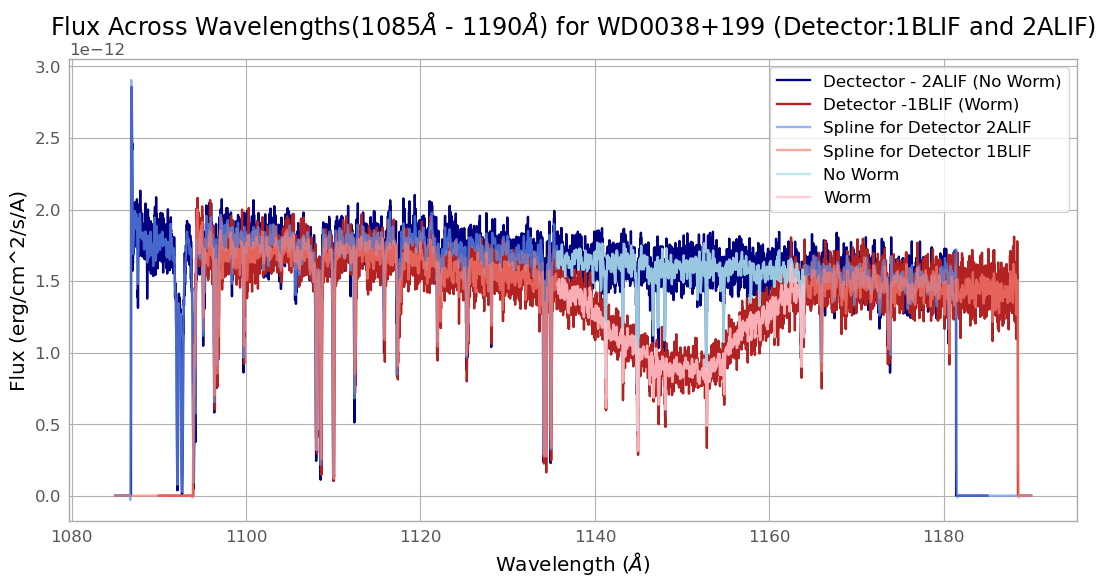

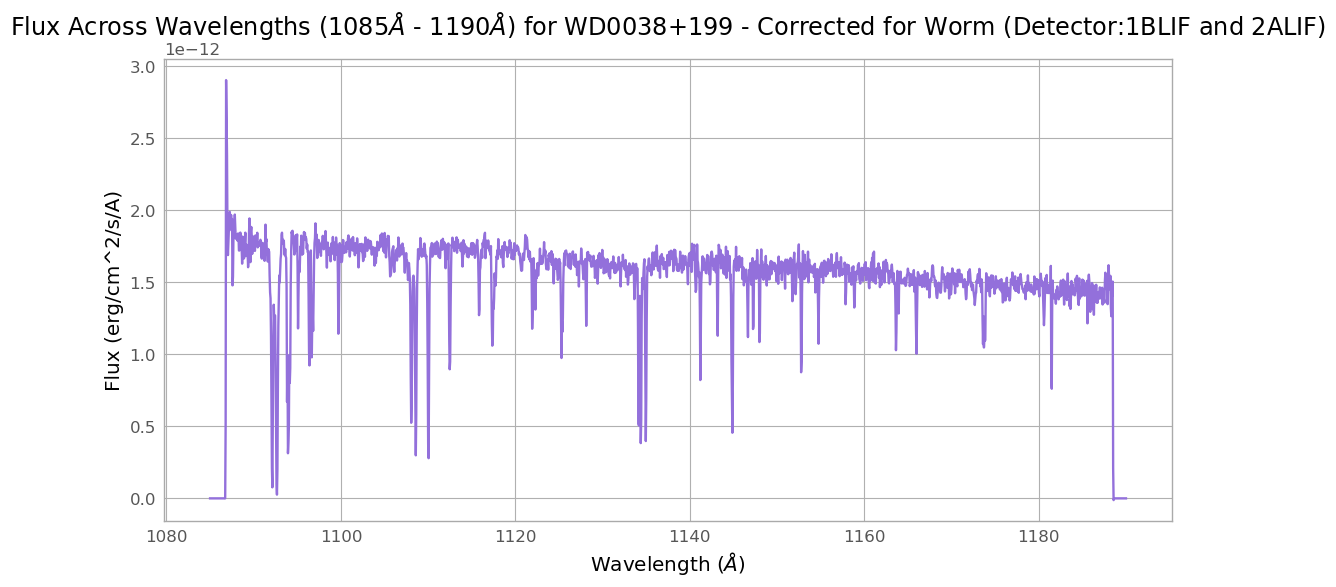

In [48]:
#For simplicity
Wavelengths_1BLiF = SpectrumData.loc['1BLIF', "Wavelengths"]
Flux_1BLiF = SpectrumData.loc['1BLIF', 'Flux']
Detector_1BLiF = SpectrumData.loc['1BLIF', 'Detector']

Wavelengths_2ALiF = SpectrumData.loc['2ALIF', "Wavelengths"]
Flux_2ALiF = SpectrumData.loc['2ALIF', 'Flux']
Detector_2ALiF = SpectrumData.loc['2ALIF', 'Detector']

#Determine location of the dip
flux_fft = rfft(np.array(Flux_1BLiF))
ten_len = floor((len(flux_fft)) * 0.01)
flux_fft[ten_len:] = 0.0
flux_inv = irfft(flux_fft)

dips,__ = sps.find_peaks(-flux_inv, prominence=0.5e-12)

#Bin the data to remove unwanted noise and outliers
stats_1BLiF, _, ___ = binned_statistic(Wavelengths_1BLiF, Flux_1BLiF, bins=(floor(len(Wavelengths_1BLiF)/3)))
stats_2ALiF, _, __ = binned_statistic(Wavelengths_2ALiF, Flux_2ALiF, bins=(floor(len(Wavelengths_2ALiF)/3)))

xvals_1BLiF = np.linspace(min(Wavelengths_1BLiF), max(Wavelengths_1BLiF), num = (floor(len(Wavelengths_1BLiF)/3)))
xvals_2ALiF = np.linspace(min(Wavelengths_2ALiF), max(Wavelengths_2ALiF), num = (floor(len(Wavelengths_2ALiF)/3)))

#Find the fit of spectrum using a spline
spl_Worm = CubicSpline(xvals_1BLiF, stats_1BLiF)
spl_NoWorm = CubicSpline(xvals_2ALiF, stats_2ALiF)
x = np.linspace(min(Wavelengths_2ALiF), max(Wavelengths_1BLiF), num = 2000)

def determine_worm(x, Wave_Dip):
    """ 
    Determines the region where the worm is located
    Inputs: 
    - x (numpy array): linspace of x values used for interpolating
    - Wave_Dip (numpy array or astropy column): wavelength where the maximum dip is (i.e. the center of the worm)

    Returns
    - Index (int): midpoint location of the worm
    """
    loc_list = []
    for i in range(0, len(x)):
        if int(x[i]) == int(Wave_Dip):
            loc_list.append(i)
    loc_list.sort()
    mid_num = int(len(loc_list)/2)
    index = loc_list[mid_num]
    return (index)

#Find the average spline
SplineAverage = (spl_NoWorm(x) + spl_Worm(x))/2

#Correct for averaging zeros
for i in range(0, len(spl_NoWorm(x))):
    if spl_NoWorm(x)[i] < 1e-15:
        SplineAverage[i] = spl_Worm(x)[i]
    elif spl_Worm(x)[i] < 1e-15:
        SplineAverage[i] = spl_NoWorm(x)[i]
    else:
        pass

index = determine_worm(x, Wavelengths_1BLiF[dips[0]])

#Replace data
SplineAverage[abs(320 - index):index + 220] = spl_NoWorm(x)[abs(320 - index):index + 220]

#Create general plot of flux across wavelengths
plt.figure(figsize = (13, 6))
plt.plot(Wavelengths_2ALiF, Flux_2ALiF, label = f"Dectector - {Detector_2ALiF} (No Worm)", color = "navy")
plt.plot(Wavelengths_1BLiF, Flux_1BLiF, label = f"Detector -{Detector_1BLiF} (Worm)", color = "firebrick")

#Plot the spline for each of them
plt.plot(x, spl_NoWorm(x), label = f"Spline for Detector {Detector_2ALiF}", color = "cornflowerblue", alpha = 0.7)
plt.plot(x, spl_Worm(x), label = f"Spline for Detector {Detector_1BLiF}", color = "salmon", alpha = 0.7)

plt.plot(x[abs(320-index): 220+index], spl_NoWorm(x)[abs(320-index): 220+index], label = "No Worm", color = "powderblue", alpha = 0.8)
plt.plot(x[abs(320-index): 220+index], spl_Worm(x)[abs(320-index): 220+index], label = "Worm", color = "pink", alpha = 0.8)

plt.grid(True)
plt.legend(loc = "upper right")
plt.xlabel("Wavelength ($\\AA$)")
plt.ylabel("Flux (erg/cm^2/s/A)")
plt.title(f"Flux Across Wavelengths({int(min(Wavelengths_2ALiF))}$\\AA$ - {int(max(Wavelengths_1BLiF))}$\\AA$) for {TargetName} (Detector:{Detector_1BLiF} and {Detector_2ALiF})")
plt.show()

#Plot average
plt.figure(figsize = (13, 6))
plt.plot(x, SplineAverage, color = 'mediumpurple')
plt.grid(True)
plt.xlabel("Wavelength ($\\AA$)")
plt.ylabel("Flux (erg/cm^2/s/A)")
plt.title(f"Flux Across Wavelengths ({int(min(Wavelengths_2ALiF))}$\\AA$ - {int(max(Wavelengths_1BLiF))}$\\AA$) for {TargetName} - Corrected for Worm (Detector:{Detector_1BLiF} and {Detector_2ALiF})")
plt.show()

### Understanding the Spectrogram
To understand what this graph is showing us, we need to compare to theoretical or accepted experimental graphs/trends. As discussed earlier, using predictions of emission spectra, we can determine different characteristics and use them for further analyses. 

For this tutorial, the objective is to analyze deuterium. We will be using this paper, [The D/H Ratio toward PG 0038+199](https://arxiv.org/pdf/astro-ph/0501320) (Williger et al., 2005) as reference (n.b. PG and WD both refer to white dwarfs). It focuses on determining the location of deuterium and provides clear references to its various locations on the spectrogram.

**Significance of Deuterium**  

Deuterium is an isotope of hydrogen, also known as Hydrogen-II, that is extremely difficult to produce due to the need for very extreme conditions. A moment in time where these conditions occured is during the Big Bang when the universe was forming. The energy was so high it allowed for the H-I to become H-II but as the universe cooled, these conditions faded leaving a finite amount of H-II or D-I in the universe. It is still possible to produce it but as stated, it is extremely difficult and current natural processes produce an insignificant amount. Celestial objects showing evidence of deuterium allows scientists to gain insight into characteristics of the target and the conditions of the early universe.  

Deuterium can also be found in our oceans and its concentration varies between water sources. Using this information, scientists can determine the source of water based on the percentage of deuterium which can be used for studies in filtration or migration patterns. 


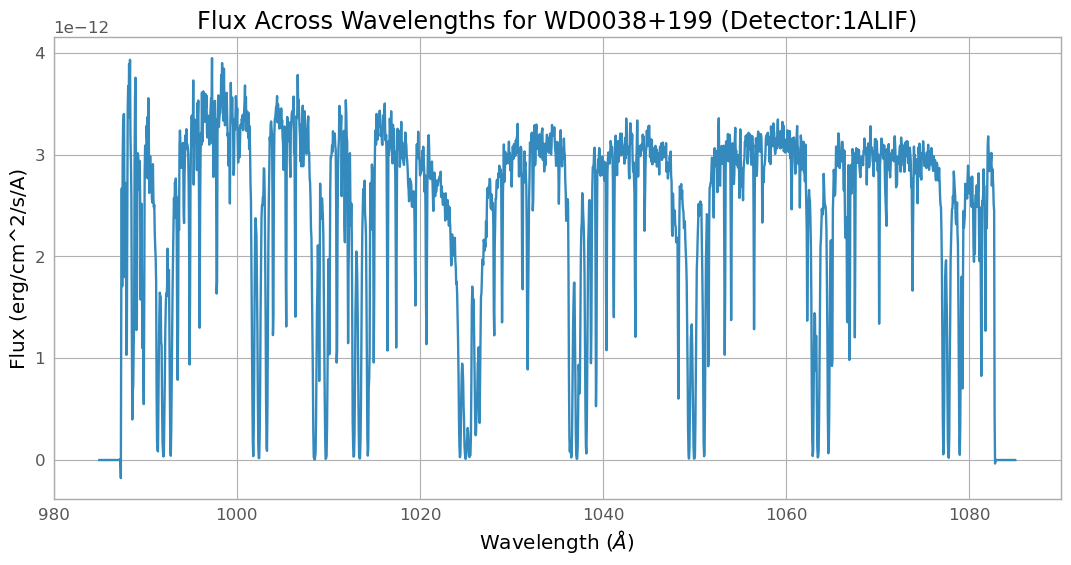

In [50]:
#Create general plot of flux across wavelengths
plt.figure(figsize = (13, 6))
plt.plot(xvals, SplineAvg_AG)
plt.grid(True)
plt.xlabel("Wavelength ($\\AA$)")
plt.ylabel("Flux (erg/cm^2/s/A)")
plt.title(f"Flux Across Wavelengths for {TargetName} (Detector:{Detector_1ALiF})")
plt.show()

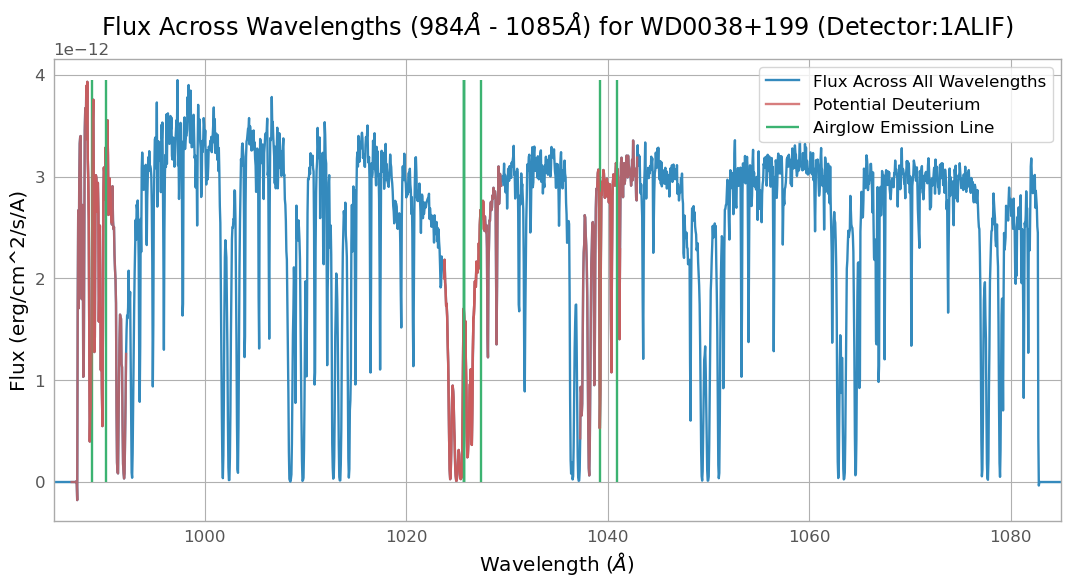

In [53]:
#To make analysis easier, we can make a new seperate dataframe for just the data in this spectrum
wave = np.array(xvals)
flux = np.array(SplineAvg_AG)
Data_df = pd.DataFrame(np.transpose(np.array([wave, flux])), columns=['WAVE', 'FLUX'])

#Create a graph highligting all the regions that potentially contain deuterium
plt.figure(figsize = (13, 6))
plt.plot(xvals, SplineAvg_AG, label = "Flux Across All Wavelengths")

for Lambda in AirglowLines:
    plt.plot(Data_df.query(f"WAVE > {Lambda - 2} and WAVE < {Lambda + 2}")["WAVE"], Data_df.query(f"WAVE > {Lambda - 2} and WAVE < {Lambda + 2}")["FLUX"], color = "indianred", alpha = 0.8)
    plt.vlines(Lambda, 0.0, max(flux), color = "mediumseagreen")

#Focusing on the specific region of airglow surrounding lambda = 972.54 angstorms
D_df = Data_df.query("WAVE > 1025.3 and WAVE < 1025.6")
D_df = D_df.reset_index(drop =True)
plt.plot(D_df['WAVE'], D_df["FLUX"], color = "indianred", alpha = 0.8, label = "Potential Deuterium")
#for labelling purposes
plt.vlines(1025.72, 0.0, max(flux), color = 'mediumseagreen', label = 'Airglow Emission Line')

plt.legend(loc = "upper right")
plt.xlim(min(xvals), max(xvals))
plt.grid(True)
plt.xlabel("Wavelength ($\\AA$)")
plt.ylabel("Flux (erg/cm^2/s/A)")
plt.title(f"Flux Across Wavelengths ({int(min(wave))}$\\AA$ - {int(max(wave))}$\\AA$) for {TargetName} (Detector:{Detector_1ALiF})")
plt.show()

As we can see there are many potential regions of deuterium. We're going to zoom in to a particular region to find exact evidence. While referencing the paper mentioned earlier by Williger et al. 

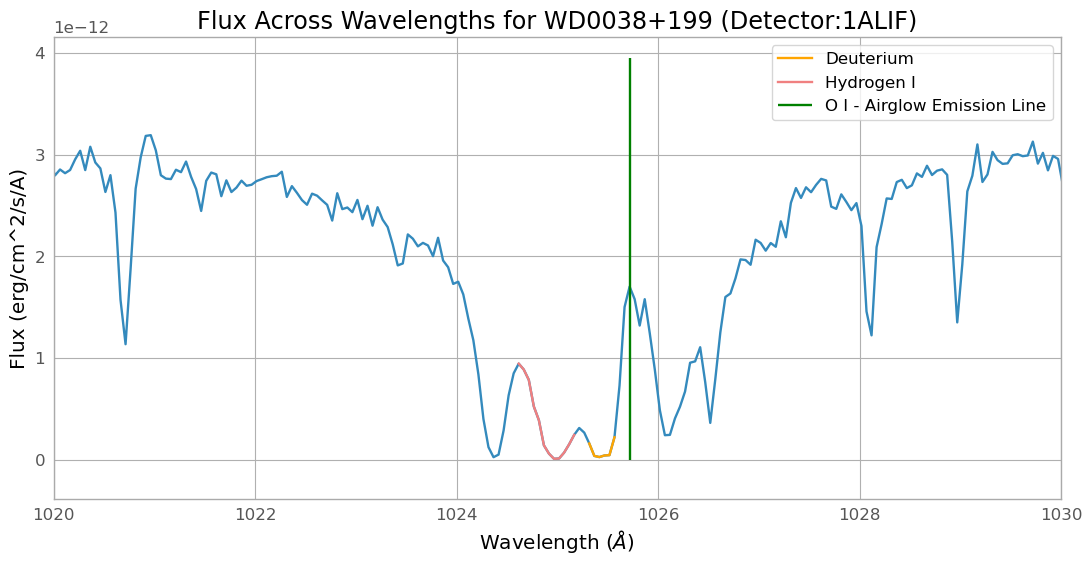

The maximum flux for deuterium in the region of emission line 1025.72 A is 2.908500135131509e-14 erg/cm^2/s/A


In [55]:
plt.figure(figsize = (13, 6))

#Extracting hydrogen into its own dataframe
H_df = Data_df.query("WAVE > 1024.6 and WAVE < 1025.2") #These values were determined by hand by analyzing the graph
H_df = H_df.reset_index(drop =True)
plt.plot(Data_df["WAVE"], Data_df["FLUX"])
plt.plot(D_df['WAVE'], D_df["FLUX"], color = "orange", label = "Deuterium")
plt.plot(H_df['WAVE'], H_df["FLUX"], color = "lightcoral", label = "Hydrogen I")
plt.vlines(1025.72, 0, max(flux), color = "green", label = "O I - Airglow Emission Line")

plt.legend()
plt.xlim(1020, 1030)
plt.grid(True)
plt.xlabel("Wavelength ($\\AA$)")
plt.ylabel("Flux (erg/cm^2/s/A)")
plt.title(f"Flux Across Wavelengths for {TargetName} (Detector:{Detector_1ALiF})")
plt.show()

#Extract deuterium
Deuterium = min(D_df['FLUX'])
print (f"The maximum flux for deuterium in the region of emission line 1025.72 A is {Deuterium} erg/cm^2/s/A")

Deuterium is one of the absportion dips here being around 0.2 angstroms in width. It's small size shows the need for high levels of precision in instruments in order to adequately understand isotopes such as deuterium.

The reason we don't see the airglow peak is because this is the data from the first section where we removed this peak.

### Plot Intensity on a Map of the Universe
To create a better visualization of the concentration of deuterium, we can plot the region on a map of the universe with a corresponding colourbar. 

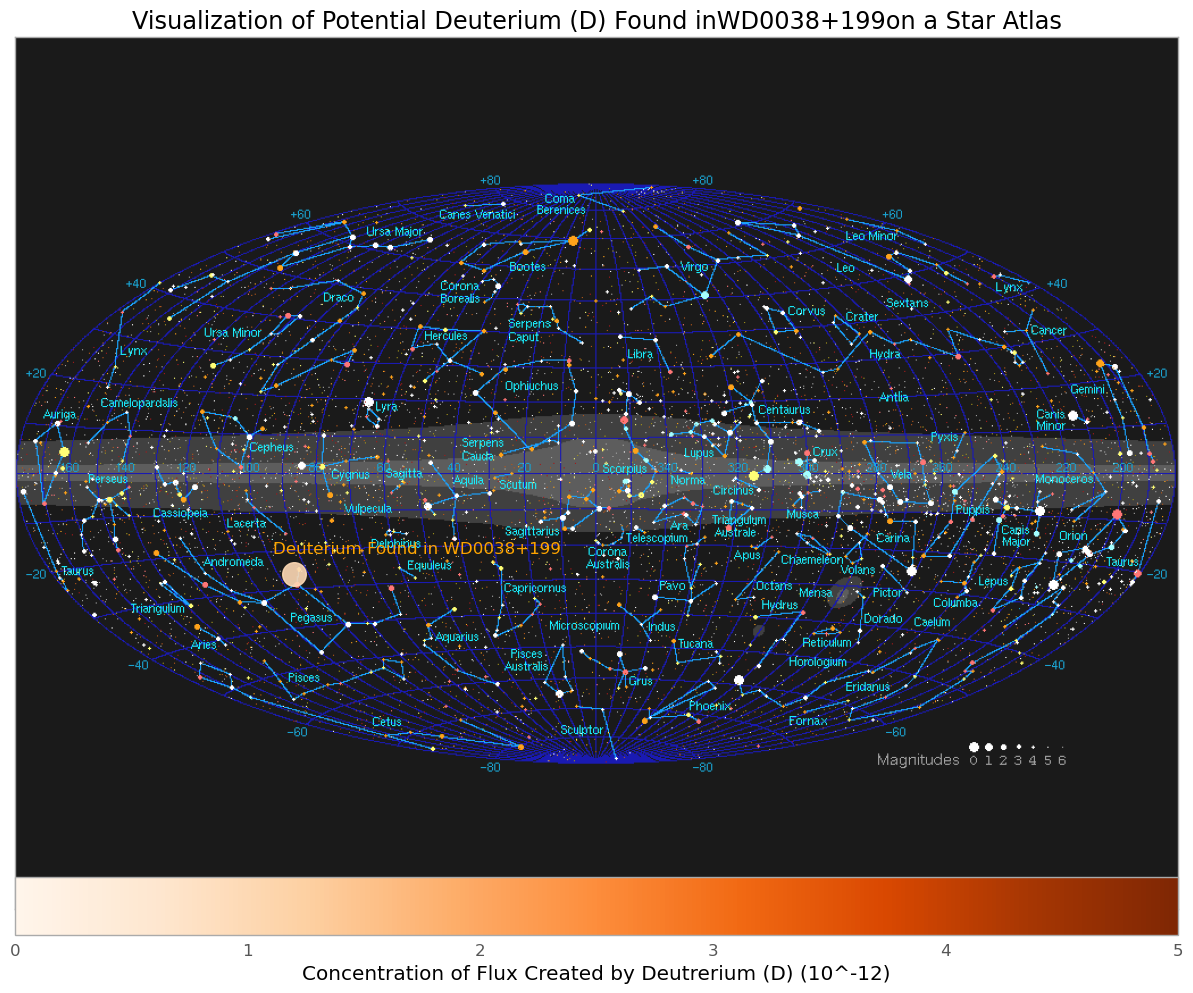

In [27]:
star_atlas_url = "http://www.atlasoftheuniverse.com/galchart.gif"

def convert_coords (ra):
    """ Converts the provided coordinate given in radians to be usable on a sky map for plotting. 
        Preferable for x-coordinate/longitude/right ascension. Y-coordinates/latitude/declination does not
        need to be converted. 

    :param ra: the provided right ascension coordinate in radians
    :type ra: float
    
    :returns ra_convert: the converted coordinates for right ascenion in radians
    :rtype ra_convert: float"""

    # Convert the right ascenion to allow it to wrap around map
    ra_convert = 0
    if ra > (np.pi):
        ra_convert = -1 * ((ra % (np.pi)) - (np.pi)) 
    else:
        ra_convert = -1 * ra
    
    return (ra_convert)

#Initialize plot
img = imread(star_atlas_url)
plt.style.use(astropy_mpl_style)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(img, alpha = 0.9)

ax2 = fig.add_subplot(projection = "aitoff")

#Implement object and convert to galactic units
object = SkyCoord(RA, DEC, unit = 'deg')
object_ra = (convert_coords(object.galactic.l.rad))
object_dec = object.galactic.b.rad

max_wave = D_df["WAVE"][np.where(max(D_df["FLUX"]) == D_df["FLUX"])[0][0]]
d = {"Max Wave": max_wave, "Max Flux": max(D_df["FLUX"]), "RA": object_ra, "DEC": object_dec, "Star Name": TargetName}
df = pd.DataFrame()
df = df._append(d, ignore_index = True)

#Plot object
cmap = plt.colormaps["Oranges"]
ax2.plot(object_ra, object_dec, marker = 'o', markersize = 17, color = cmap(df["Max Flux"][0] * 1e12), alpha = 0.9)
ax2.text(object_ra, object_dec + 0.1, "Deuterium Found in " + df["Star Name"][0], color = "orange") #Add name of the star
fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0,  5), cmap=cmap), ax = ax2, location = "bottom", orientation = "horizontal", label = "Concentration of Flux Created by Deutrerium (D) (10^-12)")

plt.axis("off")
ax.grid(False)
ax.set_title("Visualization of Potential Deuterium (D) Found in" + df["Star Name"][0] + "on a Star Atlas")
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Let's extend this to multiple objects to see contrasting concentrations. In order to do so, select and download another folder looking at a different object. Combine these two files into one folder for analyzing. 

File Name: m105121100000all4histfcal.fit
File Name: m717070200000all4ttagfcal.fit
File Name: m727210100000all4ttagfcal.fit
File Name: p104020100000all4ttagfcal.fit
File Name: u102070200000all4ttagfcal.fit
White Dwarf Dataframe
      Max Wave      Max Flux        RA       DEC   Star Name  \
0   987.425049  3.217006e-13  0.525669 -0.122482  WD1634-573   
1  1025.775024  5.105608e-14  1.368000 -0.410026  WD0715-704   
2   991.234009  1.166855e-13 -1.942462  0.586063  WD1631+781   
3  1025.709961 -1.181569e-14 -2.090703 -0.744510  WD0038+199   
4   984.994019  0.000000e+00 -2.601463  0.374315  WD0615+655   

                                         Wavelengths  \
0  1155    1000.009033
1156    1000.022034
1157  ...   
1  1155    1000.009033
1156    1000.022034
1157  ...   
2  1155    1000.009033
1156    1000.022034
1157  ...   
3  1155    1000.009033
1156    1000.022034
1157  ...   
4  1155    1000.009033
1156    1000.022034
1157  ...   

                                                Flu

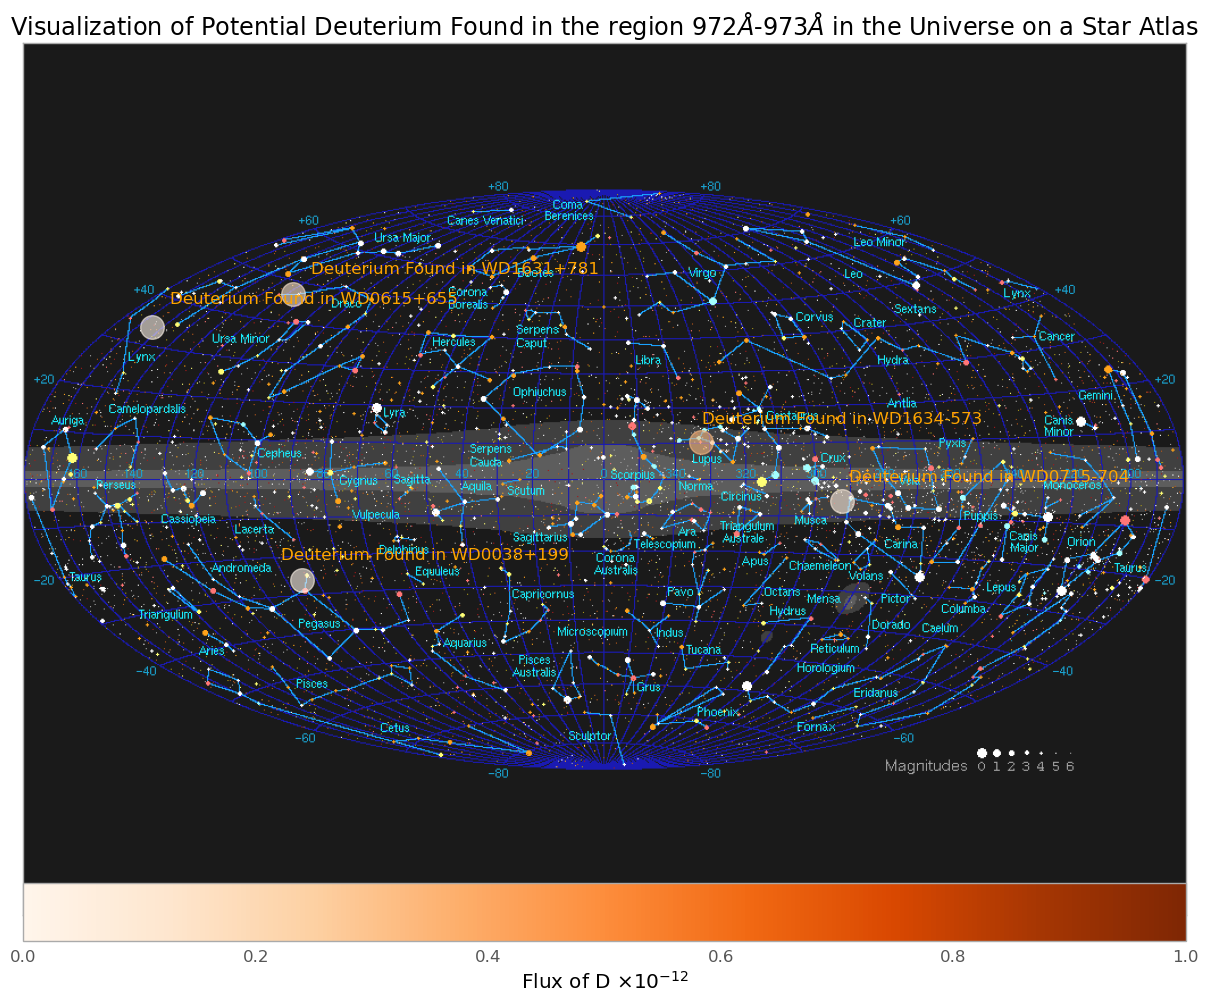

In [54]:
#Folder containing multiple images looking at different objects
#Here the files are taken out of their extracted folders and placed into a new folder which makes it easier for parsing
fuse_folder = "FUSE Tutorial"
folder_path = os.path.realpath(fuse_folder)
dir_path = os.path.dirname(folder_path)

#Extract the data from the FITS files and store in a single data frame
df = pd.DataFrame()

def extract_deterium(hdu):
    """ 
    Extract deuterium around the airglow emission 972.54 angstroms
    Inputs: 
    - hdu (astropy HDUList): the hdu of the FITS file

    Returns: 
    - d_df['WAVE'] (astropy column): wavelengths in the desired region
    - d_df['FLUX'] (astropy column): flux in the desired region
    """
    wave = Table(hdu[1].data)['WAVE']
    flux = Table(hdu[1].data)['FLUX']
    
    data_df = pd.DataFrame(np.transpose(np.array([wave, flux])), columns=['WAVE', 'FLUX'])

    d_df = data_df.query("WAVE > 1000 and WAVE < 1050")
    return (d_df['WAVE'], d_df['FLUX'])


def extract_info(hdu):
    """
    Extracts information from the FITS file
    Inputs:
    - hdu (astropy HDUList): the hdu of the FITS file

    Returns:
    - dict (dictonary): dictonary containing information about the object and the region of deuterium
    """
    data_table = Table(hdu[1].data)
    wave = data_table["WAVE"]
    flux = data_table["FLUX"]

    RA = hdu[0].header["RA_TARG"]
    DEC = hdu[0].header["DEC_TARG"]
    TargetName = hdu[0].header["TARGNAME"]
    wave_loc = np.where(flux == max(flux))[0][0]
    max_wave = wave[wave_loc]

    object = SkyCoord(RA, DEC, unit = 'deg')
    object_ra = (convert_coords(object.galactic.l.rad))
    object_dec = object.galactic.b.rad

    wave, flux = extract_deterium(hdu)
    
    dict = {"Max Wave": max_wave, "Max Flux": min(flux), "RA": object_ra, "DEC": object_dec, "Star Name": TargetName, "Wavelengths": wave, "Flux": flux}
    return (dict)

#Loop through the files and only extract info from the FITS files
directories = os.walk(dir_path)
for i in directories:
    if i[0] == dir_path:
        for file in i[2]:
            if file.endswith(".fit"):
                image = os.path.join(i[0], file)
                print (f"File Name: {file}")
                d = extract_info(fits.open(image))
                df = df._append(d, ignore_index= True)
print ("White Dwarf Dataframe")
print (df)

#Initialize plot
img = imread(star_atlas_url)
plt.style.use(astropy_mpl_style)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(img, alpha = 0.9)

ax2 = fig.add_subplot(projection = "aitoff")

cmap = plt.colormaps["Oranges"]

#Create sky map plot
for i in df.index:
    ax2.plot(df["RA"][i], df["DEC"][i], marker = 'o', markersize = 17, color = cmap(df["Max Flux"][i] * 1e12), alpha = 0.6)
    ax2.text(df["RA"][i], df["DEC"][i] + 0.1, "Deuterium Found in " + df["Star Name"][i], color = "orange") #Add name of the star


fig.colorbar(plt.cm.ScalarMappable(cmap = cmap), ax = ax2, location = "bottom", orientation = "horizontal", label = "Flux of D $\\times 10^{-12}$")
plt.axis("off")
ax.grid(False)
ax.set_title("Visualization of Potential Deuterium Found in the region 972$\\AA$-973$\\AA$ in the Universe on a Star Atlas")
ax.set_xticks([])
ax.set_yticks([])
plt.show()   


Note, we are making the assumption that deuterium will exist with the same small dip in all spectrograms across the different targets. For more accuracy, it is recommended to examine the spectrograms in the region of 1020-1030 angstroms and visually verify.

## Additonal Reading and References
The paper referenced to determine locations of deuterium   
Williger, G. M, Oliveira, C., Hebrard, G., Dupuis, J., Dreizler, S., & Moos, W. H. (2005). The D/H Ratio toward PG 0038+199. *The Astrophysical Journal*. *625*(1). https://ui.adsabs.harvard.edu/link_gateway/2005ApJ...625..210W/doi:10.1086/429315  

Additonal readings for deuterium on Earth  
https://www.iaea.org/newscenter/news/what-is-deuterium  
https://energyeducation.ca/encyclopedia/Heavy_water

Sources for airglow emission values
https://archive.stsci.edu/fuse/DH_Final/Factors_Affecting_FUSE_Data.html#SECTION001010000000000000000  
https://archive.stsci.edu/fuse/instrumenthandbook/chapter9.html     

Additonal reading about Cubic Splines  
https://towardsdatascience.com/cubic-splines-the-ultimate-regression-model-bd51a9cf396d  

More About the FUSE Mission  
Canadian Space Agency (CSA): https://www.asc-csa.gc.ca/eng/satellites/fuse.asp   
National Aeronautics and Space Administration (NASA): https://science.nasa.gov/mission/fuse  
Astro Canada: https://astro-canada.ca/le_telescope_spatial_fuse-the_fuse_space_telescope-eng  


